# Ajuste de Curva pelo Método dos Mínimos Quadrados (MMQ)

**Disciplina**: Cálculo Numérico.  
**Professor**: Marcos Maia.  
**Desenvolvido por**: Marcelo Augusto de Barros Araújo.

**Curso**: Engenharia da Computação.

**Instituição**: UABJ.

Esse relatório tem como finalidade aplicar e explicar o Método dos Mínimos Quadrados (MMQ) na prática usando o google colab para ajustar uma função aos dados históricos de fechamento diário do contrato futuro do índice Bovespa (WIN) que é a bolsa de valores do Brasil conhecida também como B3, entre os dias **09/05/2025** e **06/06/2025**.

A partir desse ajuste, buscamos:
- Analisar o comportamento do índice no período.
- Estimar o valor do fechamento para o dia seguinte (07/06/2025).
- Avaliar a qualidade do ajuste por meio da análise de resíduos.
- Construir um intervalo de confiança para a previsão, considerando uma regressão linear simples.

Todos os dados referem-se a **dias úteis**, portanto há lacunas nos finais de semana e feriados.


## Conjunto de Dados Analisado:

A tabela a seguir apresenta os valores de fechamento diário do índice WIN (contrato futuro do Ibovespa) no período entre **09/05/2025** e **06/06/2025**

**(OBS: são datas que não foram verificadas se bate realmente com valor verdadeiro é apenas uma base, levando em consideração a data da atividade)**.

Para facilitar a manipulação computacional, os dias foram codificados de forma crescente a partir do mais recente:

- O dia **0** corresponde a **06/06/2025** (último valor da série).
- O dia **–1** representa o dia anterior (05/06/2025), e assim por diante.

Essa escolha facilita a previsão para o dia seguinte, que corresponde a **x = 1**.

| Dias | Data       | WIN (Fechamento) |
|------|------------|------------------|
| 0    | 06/06/2025 | 138.455          |
| –1   | 05/06/2025 | 137.434          |
| –2   | 04/06/2025 | 138.020          |
| –3   | 03/06/2025 | 139.605          |
| –4   | 02/06/2025 | 140.285          |
| –5   | 30/05/2025 | 140.930          |
| –6   | 29/05/2025 | 139.420          |
| –7   | 28/05/2025 | 138.830          |
| –8   | 27/05/2025 | 136.290          |
| –9   | 26/05/2025 | 139.060          |
| –10  | 23/05/2025 | 141.500          |
| –11  | 22/05/2025 | 141.310          |
| –12  | 21/05/2025 | 140.325          |
| –13  | 20/05/2025 | 141.075          |
| –14  | 19/05/2025 | 140.065          |
| –15  | 16/05/2025 | 140.525          |
| –16  | 15/05/2025 | 138.620          |
| –17  | 14/05/2025 | 138.220          |
| –18  | 13/05/2025 | 138.360          |
| –19  | 12/05/2025 | 135.390          |
| –20  | 09/05/2025 | 135.665          |


Estes dados servirão de base para os ajustes e previsões a seguir.


In [ ]:
# Valores da tabela
import numpy as np
dias = np.array(range(0, -21, -1))
win = np.array([
    138455, 137434, 138020, 139605, 140285,
    140930, 139420, 138830, 136290, 139060,
    141500, 141310, 140325, 141075, 140065,
    140525, 138620, 138220, 138360, 135390,
    135665
])

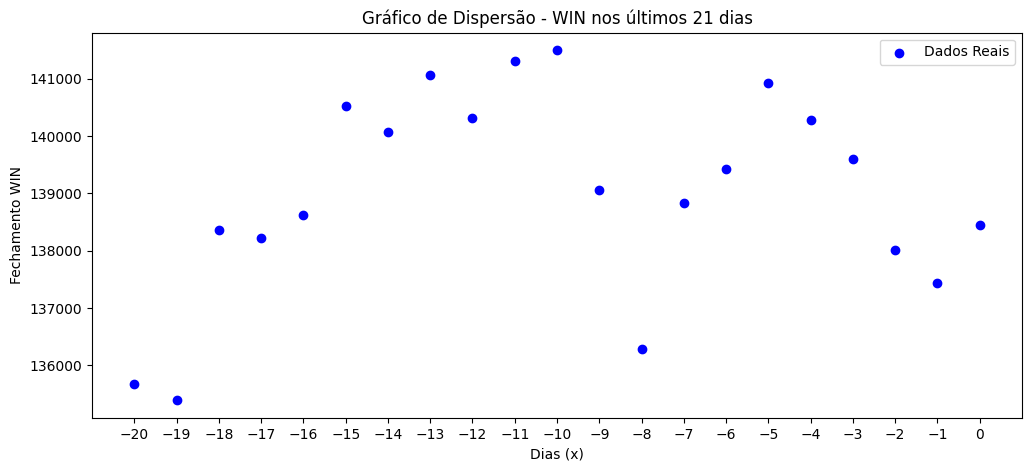

In [ ]:
# Gráfico de dispersão
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.scatter(dias, win, label='Dados Reais', color='blue')

plt.xticks(dias)
plt.xlabel('Dias (x)')
plt.ylabel('Fechamento WIN')

plt.title('Gráfico de Dispersão - WIN nos últimos 21 dias')
plt.legend()
plt.show()

## O Método dos Mínimos Quadrados (MMQ)

O Método dos Mínimos Quadrados (MMQ) é utilizado para encontrar uma função $\phi(x)$ que se aproxime dos dados observados $(x_i, y_i)$, minimizando o erro entre os valores reais e os valores ajustados.

### Construção da função ajustada

A ideia é escrever $\phi(x)$ como uma **combinação linear** de funções base $g_j(x)$:

$$
\phi(x) = \alpha_1 g_1(x) + \alpha_2 g_2(x) + \dots + \alpha_n g_n(x)
$$

O objetivo é determinar os coeficientes $\alpha_j$ que tornam essa aproximação a melhor possível, no sentido de minimizar o erro quadrático.

### Sistema $A \cdot \alpha = b$

Para isso, montamos um sistema linear da forma:

$$
A \cdot \alpha = b
$$

Onde:

- $A$ é uma matriz em que cada elemento $A_{ij}$ é o somatório do produto das funções base:  
  $$
  A_{ij} = \sum_{k=1}^{n} g_i(x_k) \cdot g_j(x_k)
  $$

- $b$ é um vetor cujos elementos são os produtos das funções base com os valores observados:  
  $$
  b_i = \sum_{k=1}^{n} g_i(x_k) \cdot y_k
  $$

- $\alpha = [\alpha_1, \alpha_2, \dots, \alpha_n]$ é o vetor de coeficientes que queremos encontrar.

Essa formulação é baseada em **produtos internos** entre os vetores das funções base e os dados observados, e garante que os resíduos sejam ortogonais ao espaço gerado pelas funções $g_j(x)$.

### Solução

Ao resolver o sistema $A \cdot \alpha = b$, obtemos os coeficientes que definem $\phi(x)$. Essa função será usada como modelo ajustado para análise e previsão.

In [ ]:
# Método dos mínimos quadrados
def mmq(funcoes, x_data, y_data):
    n = len(funcoes)
    A = np.zeros((n, n))
    b = np.zeros(n)

    for i in range(n):
        for j in range(n):
            A[i, j] = sum(funcoes[i](x) * funcoes[j](x) for x in x_data)
        b[i] = sum(y_data[k] * funcoes[i](x_data[k]) for k in range(len(x_data)))

    alfas = np.linalg.solve(A, b)

    # Determinando phi
    def phi(x):
        return sum(alfas[i] * funcoes[i](x) for i in range(n))

    return phi, alfas, A # Retorna A também

In [ ]:
# Determinado as funções
def g1(x): return 1
def g2(x): return x
def g3(x): return x**2
def g4(x): return np.cos(x/5)

funcoes = [g1, g2, g3, g4]
phi, alfas, A = mmq(funcoes, dias, win) # Recebe A aqui

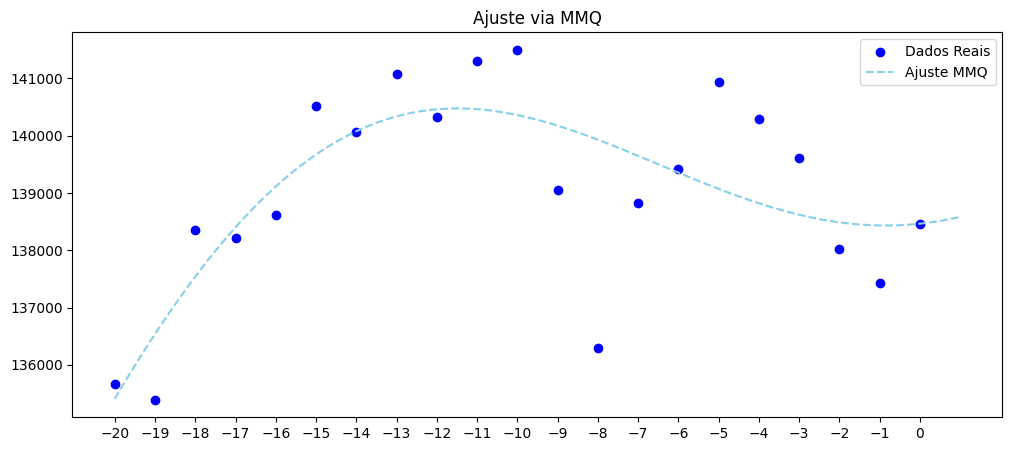

In [ ]:
# Plotando a função phi
x = np.linspace(min(dias), 1, 200)
y = [phi(xi) for xi in x]

plt.figure(figsize=(12, 5))
plt.scatter(dias, win, label='Dados Reais', color='blue')
plt.xticks(dias)
plt.plot(x, y, label='Ajuste MMQ', color='skyblue', linestyle='--')
plt.legend()
plt.title("Ajuste via MMQ")
plt.show()

In [ ]:
x_pred = 1
print(f'Previsão para o dia 07/06 (x = {x_pred}): {phi(x_pred):.3f}')

Previsão para o dia 07/06 (x = 1): 138582.719


### Erro da aproximação

O erro da aproximação é medido pela soma dos quadrados das diferenças entre os valores reais e os valores previstos pelo modelo ajustado:

$$
E = \sum_{i=1}^{n} \left( y_i - \phi(x_i) \right)^2
$$

Esse valor indica o quão bem a função ajustada representa os dados. Quanto menor o erro, melhor o ajuste.

### Análise dos resíduos

Os resíduos são definidos como a diferença entre os valores observados e os valores previstos pelo modelo:

$$
\text{Resíduo} = y_i - \phi(x_i)
$$

Se o gráfico dos resíduos mostrar curvas, agrupamentos ou tendências, isso pode indicar que o modelo não está capturando bem o comportamento dos dados.


In [ ]:
erro = sum((win[i] - phi(dias[i]))**2 for i in range(len(win)))
print(f'Erro quadrático total (EQ): {erro:.3f}')

eqm = erro / len(dias)
print(f"Erro quadrático médio (EQM): {eqm:.3f}")

Erro quadrático total (EQ): 28594904.506
Erro quadrático médio (EQM): 1361662.119


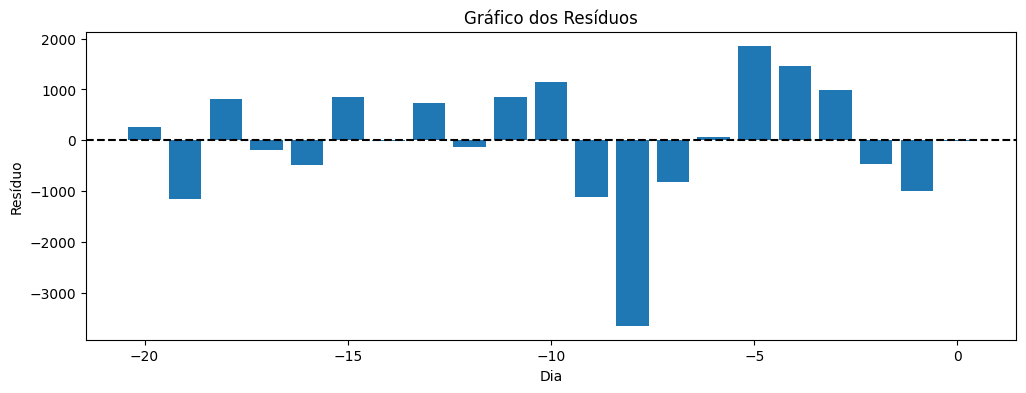

In [ ]:
residuos = np.array([win[i] - phi(dias[i]) for i in range(len(dias))])

plt.figure(figsize=(12, 4))
plt.bar(dias, residuos)
plt.axhline(0, color='black', linestyle='--')
plt.title("Gráfico dos Resíduos")
plt.xlabel("Dia")
plt.ylabel("Resíduo")
plt.show()

### Intervalo de confiança da previsão

Quando estimamos a função ajustada $\phi(x)$ por mínimos quadrados, queremos mais do que apenas uma previsão pontual: também queremos saber quão confiável é essa previsão em cada ponto $x_0$.

Para isso, calculamos a **variância da previsão** $\text{Var}[\phi(x_0)]$ — ela quantifica a incerteza do modelo no ponto $x_0$, levando em conta tanto o ruído dos dados quanto a incerteza nos coeficientes $\alpha$ (que foram estimados com base nos dados).

### Cálculo da variância de previsão

O cálculo que usamos no código segue a seguinte expressão:

$$
\text{Var}[\phi(x_0)] = \bar{\sigma}^2 \cdot \boldsymbol{g}(x_0)^T A^{-1} \boldsymbol{g}(x_0)
$$

Onde:

- $\boldsymbol{g}(x_0)$ é o vetor coluna com as funções base avaliadas no ponto $x_0$:  
  $$ \boldsymbol{g}(x_0) = \begin{bmatrix} g_1(x_0) \\ g_2(x_0) \\ \vdots \\ g_p(x_0) \end{bmatrix} $$
  
- $A$ é a matriz usada no sistema normal:  
  $$ A = \sum_{i=1}^n \boldsymbol{g}(x_i) \boldsymbol{g}(x_i)^T $$
  
- $A^{-1}$ é a inversa da matriz $A$

- $\bar{\sigma}^2$ é a variância média dos resíduos, dada por:  
  $$ \bar{\sigma}^2 = \frac{1}{n - p} \text{Erro Quadrático} $$  
  Isso representa uma estimativa do ruído nos dados com base no erro quadrático total do ajuste.

A partir dessa variância, podemos construir o intervalo de confiança da previsão usando a normalidade dos resíduos:

$$
\phi(x_0) \pm z \cdot \sqrt{ \text{Var}[\phi(x_0)] }
$$

Onde $z$ depende do nível de confiança desejado (ex: $z \approx 1.96$ para 95%).

Esse intervalo mostra a faixa onde esperamos que a verdadeira média da resposta esteja, dado o modelo e os dados observados.

In [ ]:
# Cálculo da variância estimada
n = len(dias)
p = len(funcoes)
sigma2 = erro / (n - p)  # Variância estimada do erro

print("Variância estimada:", sigma2)

Variância estimada: 1682053.2062064935


In [ ]:
# Definindo sigma2
sigma2 = eqm # Usando o erro quadrático médio como sigma2

# Inversa de A
A_inv = np.linalg.inv(A)

# Vetor g(x_pred)
g_pred = np.array([f(x_pred) for f in funcoes]).reshape(-1, 1)

# Variância da previsão
var_pred = sigma2 * (g_pred.T @ A_inv @ g_pred)[0, 0]
desvio_pred = np.sqrt(var_pred)
print("Desvio padrão previsto:", desvio_pred)

Desvio padrão previsto: 1260.1091268764033


In [ ]:
# Intervalo para 95%

z = 1.96
lim_inf = phi(x_pred) - z * desvio_pred
lim_sup = phi(x_pred) + z * desvio_pred

print(f"Intervalo de 95% para x = {x_pred}: ({lim_inf:.3f}, {lim_sup:.3f})")

Intervalo de 95% para x = 1: (136112.905, 141052.533)


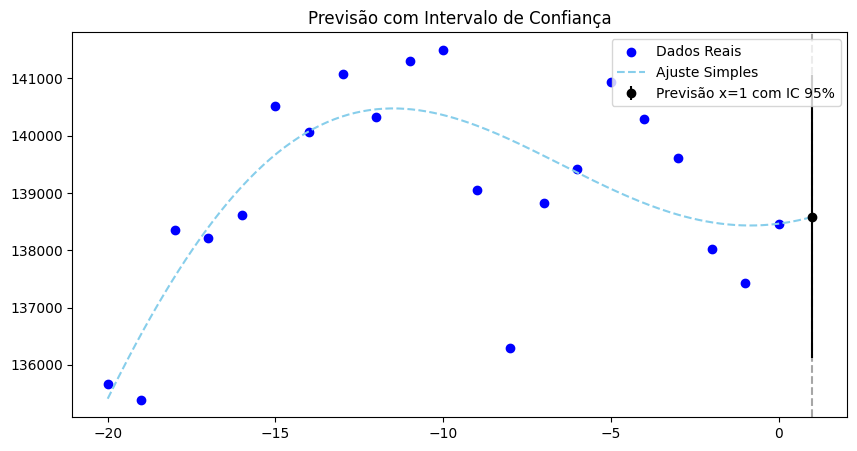

In [ ]:
plt.figure(figsize=(10, 5))
plt.scatter(dias, win, color='blue', label='Dados Reais')
plt.plot(x, y, color='skyblue', linestyle='--', label='Ajuste Simples')
plt.axvline(x=1, color='gray', linestyle='--', alpha=0.7)
plt.errorbar(1, phi(x_pred), yerr=z * desvio_pred, fmt='o', color='black', label='Previsão x=1 com IC 95%')
plt.legend()
plt.title("Previsão com Intervalo de Confiança")
plt.show()

## Discussão e Considerações Finais

Embora o ajuste de curvas pelo método dos mínimos quadrados (MMQ) seja uma ferramenta poderosa, seu uso para prever séries temporais financeiras como esta possui limitações importantes.

- Os dados apresentam ruído significativo e oscilações não periódicas, o que dificulta a modelagem com funções simples.
- O comportamento do índice WIN não segue um padrão evidente, o que **prejudica modelos determinísticos** como os utilizados aqui.
- Seria mais apropriado empregar modelos **mais robustos e especializados**, como:
  - Modelos estatísticos de séries temporais (ex: ARIMA, SARIMA),
  - Métodos baseados em aprendizado de máquina (ex: regressão por árvores, redes neurais),
  - Ou modelos híbridos que considerem também variáveis externas e tendências de mercado.

Apesar disso, a experiência foi válida para compreender os fundamentos do MMQ, suas aplicações práticas e limitações em contextos com dados reais.

Segue abaixo um exemplo de tipo de gráfico padrão no modelo de visualização de resultados aplicando previsão de séries temporais, que permite entender não apenas a estimativa pontual, mas também a incerteza associada a ela, onde A função auto_arima seleciona automaticamente os melhores parâmetros
𝑝
,
𝑑
,
𝑞
p,d,q para o modelo ARIMA, testando várias combinações e escolhendo a que minimiza critérios como o AIC ou BIC, ou seja, na prática ele automatiza a escolha dos melhores parâmetros.

O modelo ARIMA (AutoRegressive Integrated Moving Average) é amplamente usado para modelar e prever séries temporais. Sendo definido por três parâmetros:

𝑝
p: ordem da parte autorregressiva (AR) — quantos valores passados da série são usados para prever o próximo valor.

𝑑
d: ordem da diferenciação (I - Integrated) — quantas vezes a série precisa ser diferenciada para se tornar estacionária.

𝑞
q: ordem da média móvel (MA) — quantos erros passados são usados para prever o próximo valor.

Para facilitar a escolha desses parâmetros, existe a função auto_arima, que:

Testa várias combinações dos parâmetros
𝑝
,
𝑑
,
𝑞
p,d,q dentro de um intervalo definido.

Que avalia cada combinação usando critérios estatísticos, como:

AIC (Akaike Information Criterion), ou

BIC (Bayesian Information Criterion),

que medem o ajuste do modelo penalizando a complexidade para evitar overfitting(sobreajuste).

Retornando automaticamente o modelo com os melhores parâmetros, ou seja, aquele que minimiza o AIC ou BIC.

In [ ]:
pip install statsforecast


In [ ]:
import pandas as pd
import numpy as np

dias = np.array(range(0, -21, -1))
win = np.array([
    138455, 137434, 138020, 139605, 140285,
    140930, 139420, 138830, 136290, 139060,
    141500, 141310, 140325, 141075, 140065,
    140525, 138620, 138220, 138360, 135390,
    135665
])

# Definindo a data do dia 0 como 06/06/2025
current_date = pd.to_datetime("2025-06-06")

# Criando as datas reais a partir da referência
ds = [current_date + pd.Timedelta(days=int(d)) for d in dias]

# Criar o DataFrame
df = pd.DataFrame({
    'unique_id': 'WIN',
    'ds': ds,
    'y': win
})

# Ordenar o DataFrame
df = df.sort_values(by='ds').reset_index(drop=True)
df.to_csv('win_data.csv', index=False)
print('Dados preparados e salvos em win_data.csv')




Dados preparados e salvos em win_data.csv


In [ ]:
import pandas as pd
from statsforecast import StatsForecast
from statsforecast.models import Naive, SeasonalNaive, AutoARIMA, AutoETS

# Carregar os dados preparados
df = pd.read_csv("win_data.csv", parse_dates=["ds"])

# Definir os modelos
models = [
    Naive(),
    SeasonalNaive(12),
    AutoARIMA(d=1, start_p=6, max_p=12, start_q=6, max_q=12, trace=True, stepwise=False),
    AutoETS()
]

# Inicializar o StatsForecast
sf = StatsForecast(
    models=models,
    freq='D'
)

# Treinar o modelo e gerar previsões
# Definir o horizonte de previsão (por exemplo, 7 dias)
h = 7
forecast_df = sf.forecast(df=df, h=h, level=[95])

print(forecast_df.head())
print(forecast_df.tail())

forecast_df.to_csv("forecast_results.csv", index=False)




ARIMA(0,1,0)                   :350.5939643207348

ARIMA(0,1,0) with drift        :352.8957256054992

ARIMA(0,1,1)                   :353.07187502595315

ARIMA(0,1,1) with drift        :355.67725746993017

ARIMA(0,1,2)                   :355.433755528171

ARIMA(0,1,2) with drift        :358.36847030991794

ARIMA(0,1,3)                   :358.09367365326864

ARIMA(0,1,3) with drift        :361.37802595270654

ARIMA(0,1,4)                   :361.4983677720442

ARIMA(0,1,4) with drift        :365.1900548099023

ARIMA(0,1,5)                   :365.6923778224724

ARIMA(0,1,5) with drift        :inf

ARIMA(1,1,0)                   :353.0731043302057

ARIMA(1,1,0) with drift        :355.68424981917053

ARIMA(1,1,1)                   :355.8694625079451

ARIMA(1,1,1) with drift        :358.91856300949104

ARIMA(1,1,2)                   :358.55660275369195

ARIMA(1,1,2) with drift        :362.53451845977264

ARIMA(1,1,3)                   :362.05428884685927

ARIMA(1,1,3) with drift        :366

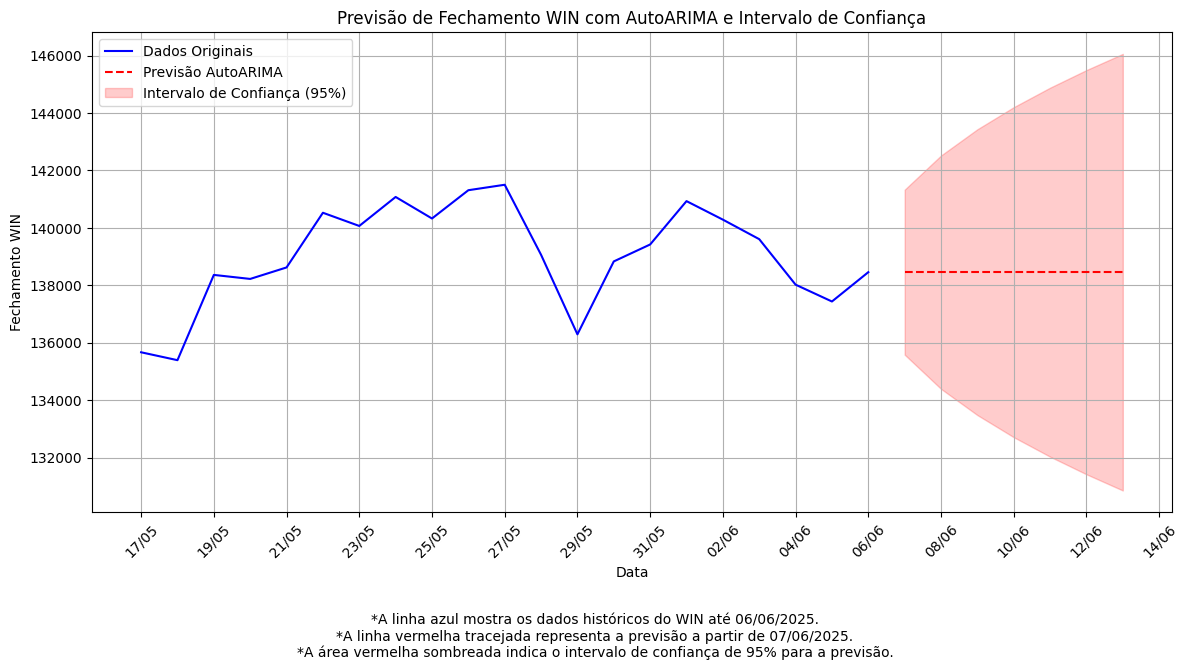

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Carregar os dados originais
df_original = pd.read_csv("win_data.csv", parse_dates=["ds"])

# Carregar os resultados da previsão
forecast_df = pd.read_csv("forecast_results.csv", parse_dates=["ds"])

# Filtrar apenas as previsões do AutoARIMA
autoarima_forecast = forecast_df[["ds", "AutoARIMA", "AutoARIMA-lo-95", "AutoARIMA-hi-95"]]

# Plotar os dados originais
plt.figure(figsize=(12, 6))
plt.plot(df_original["ds"], df_original["y"], label="Dados Originais", color="blue")

# Plotar a previsão do AutoARIMA
plt.plot(autoarima_forecast["ds"], autoarima_forecast["AutoARIMA"], label="Previsão AutoARIMA", color="red", linestyle="--")

# Plotar o intervalo de confiança
plt.fill_between(
    autoarima_forecast["ds"],
    autoarima_forecast["AutoARIMA-lo-95"],
    autoarima_forecast["AutoARIMA-hi-95"],
    color="red",
    alpha=0.2,
    label="Intervalo de Confiança (95%)"
)

plt.xlabel("Data")
plt.ylabel("Fechamento WIN")
plt.title("Previsão de Fechamento WIN com AutoARIMA e Intervalo de Confiança")
plt.legend()
plt.grid(True)
# Formatador de data para exibir como "dd/mm"
date_format = mdates.DateFormatter('%d/%m')

# Aplica o formatador ao eixo x
plt.gca().xaxis.set_major_formatter(date_format)

# Define espaçamento entre as datas do eixo x (a cada 2 dias, por exemplo)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2))

# Rotaciona as datas para melhor visualização
plt.xticks(rotation=45)
# Adiciona explicação abaixo do gráfico
plt.figtext(0.5, -0.1,
            '*A linha azul mostra os dados históricos do WIN até 06/06/2025.\n'
            '*A linha vermelha tracejada representa a previsão a partir de 07/06/2025.\n'
            '*A área vermelha sombreada indica o intervalo de confiança de 95% para a previsão.',
            wrap=True, horizontalalignment='center', fontsize=10)

plt.tight_layout()
plt.savefig("forecast_plot.png", bbox_inches='tight')  # Garante que o texto não será cortado
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
#Atividade feita em sala no laboratório de informática da UABJ 11/06/25.

In [ ]:
y = [
135665,
135390,
138360,
138220,
138620,
140525,
140065,
141075,
140325,
141310,
141500,
139060,
136290,
138830,
139420,
140930,
140285,
139605,
138020,
137434,
138455]

x = [i-20 for i in range(0,21)]
print (x)

[-20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0]


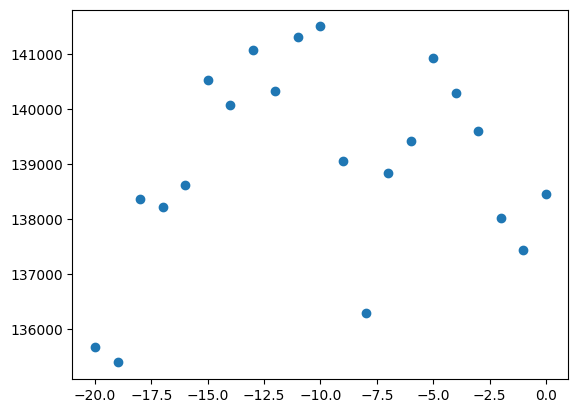

In [ ]:
plt.plot(x,y, 'o')
plt.show()

In [ ]:
#define as funções a serem ajustadas
g = [lambda r: 1 if isinstance (r, int)  else np.ones(len(r)),
     lambda r: np.array(r),
     lambda r: np.pow(r,2),
     lambda r: np.exp(r),
     lambda r: np.sin(r),
     lambda r: np.cos(r),
     lambda r: np.tan(r)
     ]

#dimensão do sistema linear
n= len(g)

#Matriz dos coeficcientes
G = [[sum(g[i](x)*g[j](x))for i in range(n)] for j in range (n)]

# print(G)

b = [sum(g[i](x)*y) for i in range(n)]
# print(b)

#Resolve sistema linear G * a = b
a = np.linalg.solve(G, b)
print(a)


[ 1.36857318e+05 -7.13859244e+02 -3.70819957e+01  1.98594506e+03
  8.99774748e+02 -2.76037142e+02  3.42644243e-01]


In [ ]:
#define a função de ajuste total
def phi(r):
  s = 0
  for i in range(n):
     s = s+ a[i]*g[i](r)
  return s
# previsão do preço para o próximo dia
print(phi(1))

142113.25971811713


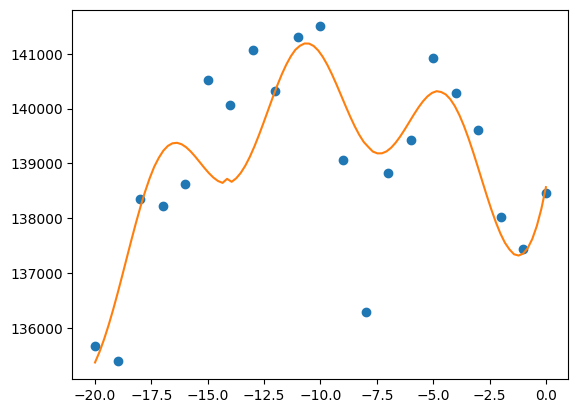

In [ ]:
x_aux = np.linspace(min(x), max(x), 100)
y_ajustado = phi(x_aux)

plt.plot(x, y, 'o') #pontos originais
plt.plot (x_aux, y_ajustado) #curva ajustada

plt.show()

In [ ]:
#calcular o erro médio de ajuste

#para cada ponto x_k (tabelado) faça:
#erro = abs(y_k - phi(x_k))
#acumula o erro e divide pela quantidade de pontos tabelados

# erro = sum((x_k[i] - phi(x_k)**2 for i in range(len(win)))
# print(f'Erro quadrático total (EQ): {erro:.3f}')

# eqm = erro / len(dias)
# print(f"Erro quadrático médio (EQM): {eqm:.3f}")


for i in range(len(x)):
  erro = abs(y[i] - phi(x[i]))**2
print(f'Erro quadrático total (EQ): {erro:.3f}')

medio = erro / len(x)
print(f"Erro quadrático médio (EQM): {medio:.3f}")

err = sum([abs(y[i] - phi(x[i])) for i in range(len(x))])/len(x)
print(f"Erro Absoluto normal: {err:.3f}")


Erro quadrático total (EQ): 12594.683
Erro quadrático médio (EQM): 599.747
Erro Absoluto normal: 760.634
